# Processing of the data

In this interactive script, I'm going to process the data found in `letters.json` for the following:

+ tf-idf scores, which ought to be a good measure of the uniqueness of the words contained in a letter to the
letter itself, which will be deployed in clustering based on *authorship*; and,
+ sentiments, which will be deployed in testing the hypothesis that the sentiment of the correspondence will co-occur with 
important contemporaneous historical events.

## Term Frequency–Inverse Document Frequency Scores

Given `letters.json`, we will be creating a new `pd.Dataframe` which captures only the important information for authorship-analysis:
1. The author of the text, which is retrieved from the title by the following method: `letter['meta-title'].split('mit')[1].strip()` (each title is 
formatted such that the author is included after the 'mit'); and,
2. The text, which will be broken up into individual words, with their frequencies.

In [6]:
import pandas as pd
import numpy as np
import nltk

letters_df = pd.read_json("letters.json")
letters_df.head()

,meta-date,meta-href,meta-text,meta-title,meta-author
0,01.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Peter Imandt
1,02.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n \n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Karl Marx
2,04.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Manchr 4 Janr\n1866.\nL...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Friedrich Engels
3,05.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | 5 January 1866.\nDear F...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Friedrich Engels
4,08.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n \n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Sigismund Ludwig Borkheim


In [7]:
freqs_df = letters_df[["meta-author", "meta-text"]]
freqs_df.head()

,meta-author,meta-text
0,Peter Imandt,\n\n ...
1,Karl Marx,\n\n \n ...
2,Friedrich Engels,\n\n | Manchr 4 Janr\n1866.\nL...
3,Friedrich Engels,\n\n | 5 January 1866.\nDear F...
4,Sigismund Ludwig Borkheim,\n\n \n ...


In [8]:
from nltk.corpus import stopwords
# Collect all of the words from each individual letter into a set, and,
# create a dictionary of the frequency distributions of the words in general.
words = set()
texts = freqs_df["meta-text"]
freq_dicts = []

for text in texts:
    tokens = nltk.word_tokenize(text)
    for token in tokens:
        words.add(token)
    freq_dicts.append(nltk.FreqDist(tokens))

In [9]:
# Update the dictionaries to acconut for words that are *not* present.
for d in freq_dicts:
    for word in words:
        if word not in d:
            d[word] = 0
        else:
            d[word] = d[word]

In [10]:
# Turn the list[dict[str, int]] into a dict[str, list[int]]
freq_dict = {}

for d in freq_dicts:
    for key, value in d.items():
        if key in freq_dict:
            freq_dict[key].append(value)
        else:
            freq_dict[key] = [value]

In [11]:
non_tfidf_df = pd.concat([freqs_df, pd.DataFrame(freq_dict)], ignore_index=False, axis=1)
non_tfidf_df.head()

,meta-author,meta-text,|,Mittwoch,Lieber,Marx,",",Sei,so,gut,...,épreuves,bludgeons,établir,page,Russophobie,Schweinhunds,vorherzusehn,Schick,Vorsehung,Gebirgsgegend
0,Peter Imandt,\n\n ...,1,1,1,1,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Karl Marx,\n\n \n ...,3,0,0,2,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Friedrich Engels,\n\n | Manchr 4 Janr\n1866.\nL...,2,0,1,0,12,0,6,1,...,0,0,0,0,0,0,0,0,0,0
3,Friedrich Engels,\n\n | 5 January 1866.\nDear F...,2,0,0,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sigismund Ludwig Borkheim,\n\n \n ...,1,0,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
non_tfidf_df.to_csv("non_tf_idf.csv")

In [13]:
# For safekeeping
non_tfidf_df[non_tfidf_df.легко > 0]

,meta-author,meta-text,|,Mittwoch,Lieber,Marx,",",Sei,so,gut,...,épreuves,bludgeons,établir,page,Russophobie,Schweinhunds,vorherzusehn,Schick,Vorsehung,Gebirgsgegend
487,Sigismund Ludwig Borkheim,\n\n | London den 12ten Januar...,2,0,1,3,32,0,2,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Now we can get our tf-idf scores.
import sklearn.feature_extraction.text as skl

trfmr = skl.TfidfTransformer()

non_tfidf_df.head()

,meta-author,meta-text,|,Mittwoch,Lieber,Marx,",",Sei,so,gut,...,épreuves,bludgeons,établir,page,Russophobie,Schweinhunds,vorherzusehn,Schick,Vorsehung,Gebirgsgegend
0,Peter Imandt,\n\n ...,1,1,1,1,3,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Karl Marx,\n\n \n ...,3,0,0,2,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Friedrich Engels,\n\n | Manchr 4 Janr\n1866.\nL...,2,0,1,0,12,0,6,1,...,0,0,0,0,0,0,0,0,0,0
3,Friedrich Engels,\n\n | 5 January 1866.\nDear F...,2,0,0,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sigismund Ludwig Borkheim,\n\n \n ...,1,0,1,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
freqs = non_tfidf_df.drop(columns=["meta-author", "meta-text"])
result = trfmr.fit_transform(freqs)
res_df = pd.concat([freqs_df, pd.DataFrame(result.toarray(), columns=freqs.columns)], axis=1)
res_df

/Users/connorhanley/anaconda3/envs/lingstats/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/connorhanley/anaconda3/envs/lingstats/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/connorhanley/anaconda3/envs/lingstats/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/connorhanley/anaconda3/envs/lingstats/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarn

,meta-author,meta-text,|,Mittwoch,Lieber,Marx,",",Sei,so,gut,...,épreuves,bludgeons,établir,page,Russophobie,Schweinhunds,vorherzusehn,Schick,Vorsehung,Gebirgsgegend
0,Peter Imandt,\n\n ...,0.025163,0.108776,0.039701,0.048237,0.076048,0.132917,0.036335,0.062143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Karl Marx,\n\n \n ...,0.031307,0.000000,0.000000,0.040009,0.262819,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Friedrich Engels,\n\n | Manchr 4 Janr\n1866.\nL...,0.023661,0.000000,0.018665,0.000000,0.143016,0.000000,0.102498,0.029216,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Friedrich Engels,\n\n | 5 January 1866.\nDear F...,0.025783,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sigismund Ludwig Borkheim,\n\n \n ...,0.032088,0.000000,0.050626,0.061511,0.193952,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,Karl Marx,\n\n | 9 Bolton St W24 Dec\n ...,0.026618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1217,Hermann Jung,\n\n | 4 Charles StreetNortham...,0.026387,0.000000,0.000000,0.050582,0.053164,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1218,Louis Kugelmann,"\n\n | Hannover, 29. Dcbr.\n ...",0.027209,0.000000,0.000000,0.026079,0.123346,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1219,Hermann Jung,\n\n \n ...,0.050853,0.000000,0.000000,0.024371,0.089651,0.000000,0.018358,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
tfidf_df = res_df
tfidf_df.to_csv("tf_idf.csv")

# Language detection and sentiment analysis

Now that we have our tf-idf scores as well as basic word frequency (tbd if either of them is more effective at determining *authorship*),
the next step is to acquire the sentiment values of each letter, and then see if there is any statistically significant co-occurrence of certain sentiments
with historical events. 

This process, unlike above, requires that we first *detect* the language which we will be classifying, and then applying some basic sentiment
analysis to it.

In [17]:
import langdetect as ld

meta_lang = []
for text in letters_df["meta-text"]:
    lang = ld.detect(text)
    if lang == "bg":
        meta_lang.append('ru')
    else:
        meta_lang.append(lang)

langs_df = pd.concat([letters_df, pd.DataFrame({"meta-lang": meta_lang})], axis=1)
langs_df.head()

,meta-date,meta-href,meta-text,meta-title,meta-author,meta-lang
0,01.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Peter Imandt,de
1,02.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n \n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Karl Marx,de
2,04.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Manchr 4 Janr\n1866.\nL...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Friedrich Engels,de
3,05.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | 5 January 1866.\nDear F...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Friedrich Engels,de
4,08.01.1866,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n \n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Sigismund Ludwig Borkheim,de


In [18]:
# Now that we've detected the languages that are in the texts,
# we can see what unique languages there are.
set(meta_lang)
# changed it from `bg` to `ru`, because i *know* it's not bulgarian.

{'de', 'en', 'fr', 'ru'}

## Sentiment analysis

Now that we've acquired the different languages, we need to find sufficiently acceptable models that can do basic sentiment
analysis on the texts themselves. For English, we will be using the basic sentiment provided by `nltk`, and then for French, German, and Russian,
we will be using libraries https://huggingface.co/tblard/tf-allocine?text=Je+t%27appr%C3%A9cie+beaucoup.+Je+t%27aime., https://huggingface.co/oliverguhr/german-sentiment-bert,
and finally https://huggingface.co/seara/rubert-tiny2-russian-sentiment. We've taken the liberty of encapsulating most of the code away in 
`./sentiments.py`, providing only `en, ru, de, fr` as the interfaces to these models. Similarly, we have provided a standard `SentimentValue` class that 
captures all of the different variations of sentiment ratings that the different models return.

Actually, given that the Russian is literally just one text, we're going to ignore it!

In [19]:
from sentiments import en, ru, de, fr

## Breaking up the data

Because of the sheer quantity of data present, sentiment analysis takes a long time, let's do some exploratory analysis to determine if there any trends of letters.

In [20]:
from copy import deepcopy 

dates_df = deepcopy(langs_df)


In [21]:
# Fix the date time
import re

def fix_datetime(datestr):
    match_str = r"\d+\.\d+\.\d+"
    return re.findall(match_str, datestr)[0]

dates_df["meta-date"] = [fix_datetime(date) for date in dates_df["meta-date"]]
dates_df["meta-date"] = pd.to_datetime(dates_df["meta-date"], format="%d.%m.%Y")

In [22]:
dates = dict()

for date in dates_df["meta-date"]:
    dfs = dates_df[dates_df["meta-date"] == date]
    ens = len(dfs[dfs["meta-lang"] == "en"])
    frs = len(dfs[dfs["meta-lang"] == "fr"])
    des = len(dfs[dfs["meta-lang"] == "de"])
    rus = len(dfs[dfs["meta-lang"] == "ru"])
    if date in dates:
        dates[date]["en"] += ens
        dates[date]["fr"] += frs
        dates[date]["de"] += des
        dates[date]["ru"] += rus
    else:
        dates[date] = dict()
        dates[date]["en"] = ens
        dates[date]["fr"] = frs
        dates[date]["de"] = des
        dates[date]["ru"] = rus

dates

{Timestamp('1866-01-01 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-02 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-04 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-05 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-08 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-09 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-13 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-14 00:00:00'): {'en': 0, 'fr': 1, 'de': 0, 'ru': 0},
 Timestamp('1866-01-15 00:00:00'): {'en': 0, 'fr': 10, 'de': 15, 'ru': 0},
 Timestamp('1866-01-18 00:00:00'): {'en': 8, 'fr': 0, 'de': 8, 'ru': 0},
 Timestamp('1866-01-20 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-21 00:00:00'): {'en': 1, 'fr': 0, 'de': 0, 'ru': 0},
 Timestamp('1866-01-24 00:00:00'): {'en': 0, 'fr': 0, 'de': 1, 'ru': 0},
 Timestamp('1866-01-26 00:00:00'): {'en': 0, 'fr'

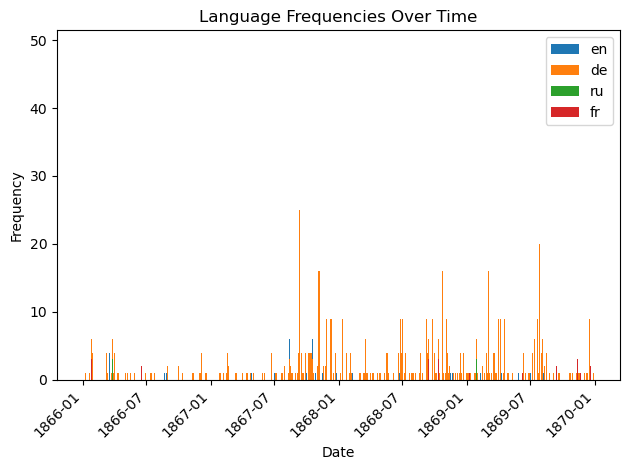

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

ds = list(dates.keys())
languages = ['en', 'de', 'ru', 'fr']

for language in languages:
    freqs = [entry[language] for entry in dates.values()]
    plt.bar(ds, freqs, label=language)

plt.xticks(rotation=45, ha="right")
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Language Frequencies Over Time')
plt.legend()

plt.tight_layout()
plt.show()


## Random sampling

Interestingly, there seems to be a weight towards later dates for the amountt of letters- specifically in German. To that end, I'm going to pick out a random $20$ letters from each year (hopefully), 
which ought to narrow down the analysis as well as make it a bit random, in the spirit of a good statistician.

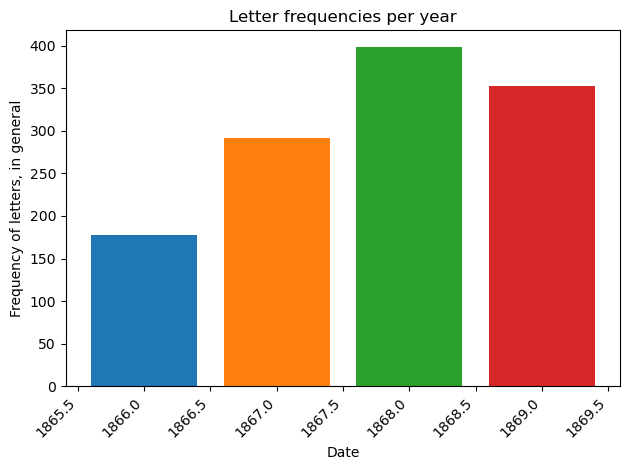

In [48]:
year_quantities = {}
for date in ds:
    years = [y_df for y_df in dates_df["meta-date"] if y_df.year == date.year]
    if date.year in year_quantities:
        continue
    else:
        year_quantities[date.year] = len(years)

years = sorted(set([date.year for date in ds]))

for year in years:
    plt.bar(year, year_quantities[year])

plt.xticks(rotation=45, ha="right")
plt.xlabel('Date')
plt.ylabel('Frequency of letters, in general')
plt.title('Letter frequencies per year')

plt.tight_layout()
plt.show()

Given that each year has $< 200$ letters in it, a safe number from each year might just be a random $150$.

In [67]:
per_year_dfs = {}
for year in years:
    per_year_dfs[year] = dates_df[dates_df["meta-date"].dt.year == year].sample(150)

per_year_df = pd.concat(per_year_dfs.values())
per_year_df

,meta-date,meta-href,meta-text,meta-title,meta-author,meta-lang
82,1866-05-31,https://megadigital.bbaw.de/briefe/detail.xql?...,"\n\n | 47, Princess Street,Man...",\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Ernest (Ernst) Charles Jones,en
76,1866-05-16,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Mchr 16 Mai 1866.\nLieb...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Friedrich Engels,de
132,1866-09-05,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | 5 Sept. 1866.\nMy belov...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Karl Marx,en
129,1866-08-31,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | 18 Bouverie StFriday Af...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,William Randall Cremer,en
156,1866-11-12,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Londres. 12 Nov.\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,François Lafargue,fr
...,...,...,...,...,...,...
970,1869-04-12,https://megadigital.bbaw.de/briefe/detail.xql?...,"\n\n | 3 Old Hill,\n ...",\n\nVorheriger Brief\nBriefe im Jahr 1869\nNch...,John Malcolm Forbes Ludlow,en
1184,1869-11-13,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | den 13 Nov. 69.\nLieber...,\n\nVorheriger Brief\nBriefe im Jahr 1869\nNch...,Wilhelm Liebknecht,de
982,1869-04-24,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | London 24 April.\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1869\nNch...,Friedrich Engels,de
968,1869-04-12,https://megadigital.bbaw.de/briefe/detail.xql?...,"\n\n | Berlin, Montag\nLieber ...",\n\nVorheriger Brief\nBriefe im Jahr 1869\nNch...,Friedrich Engels,de


## Actual sentiment analysis

Now that we've finally got a random sampling of 150 letters per year, we can begin doing sentiment analysis. 

In [76]:
from sentiments import SentimentLabel
str(SentimentLabel.pos)

'pos'

In [78]:
def process(text, label):
    if label == "en":
        res = en.process(text)
        return f"('{res.label}', {res.value})"
    elif label == "de":
        res = de.process(text)
        return f"('{res.label}', {res.value})"
    elif label == "fr":
        res = fr.process(text[:515])
        return f"('{res.label}', {res.value})"

per_year_df["meta-sentiment"] = per_year_df.apply(lambda row: process(row["meta-text"], row["meta-lang"]), axis=1)
per_year_df.sample(20)

,meta-date,meta-href,meta-text,meta-title,meta-author,meta-lang,meta-sentiment
1207,1869-12-15,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Leanington Place15/12.\...,\n\nVorheriger Brief\nBriefe im Jahr 1869\nNch...,Friedrich Engels,de,"('neu', 0.9848243594169617)"
586,1868-05-01,https://megadigital.bbaw.de/briefe/detail.xql?...,"\n\n | Barmen, d. 1. Mai\n ...",\n\nVorheriger Brief\nBriefe im Jahr 1868\nNch...,Friedrich Engels,de,"('neg', 0.6140905022621155)"
416,1867-11-28,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Mchr 28 Novbr 1867.\nLi...,\n\nVorheriger Brief\nBriefe im Jahr 1867\nNch...,Friedrich Engels,de,"('neu', 0.9854534864425659)"
147,1866-10-11,https://megadigital.bbaw.de/briefe/detail.xql?...,"\n\n | Hannover, 11. Octob. 18...",\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Louis Kugelmann,de,"('neu', 0.9885977506637573)"
854,1868-12-21,https://megadigital.bbaw.de/briefe/detail.xql?...,"\n\n | Berlin, 21. December\n ...",\n\nVorheriger Brief\nBriefe im Jahr 1868\nNch...,Wilhelm Eichhoff,de,"('neu', 0.9878872632980347)"
140,1866-09-27,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Sunny Bank-Hunsey Lane2...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Collet Dobson Collet,en,"('pos', 0.137)"
809,1868-11-20,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | 20/XI\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1868\nNch...,Karl Marx,fr,"('pos', 0.7031952142715454)"
771,1868-10-27,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | Leipzig. d. 27/10.\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1868\nNch...,Karl Marx,de,"('neu', 0.9958933591842651)"
991,1869-04-30,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n | 10 Brunswick\n ...,\n\nVorheriger Brief\nBriefe im Jahr 1869\nNch...,Sigismund Ludwig Borkheim,de,"('neg', 0.9905023574829102)"
41,1866-03-27,https://megadigital.bbaw.de/briefe/detail.xql?...,\n\n \n ...,\n\nVorheriger Brief\nBriefe im Jahr 1866\nNch...,Sigismund Ludwig Borkheim,ru,None


## Evaluating sentiment

Now that we've retrieved sentiment, see if we can graph it out to see if there are any trends. For classification, I've take it to be a ternary classification of some label `['pos', 'neg', 'neu']`, with an associated `value: float`.

In [1]:
# per_year_df.to_csv("per_year_sentiment.csv")

NameError: name 'per_year_df' is not defined